A pipe line using 3 datasets, vanilla denoising AE, iNNvestiage backtrace, then PCA and TSNE.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [1]:
import keras
from keras.layers import Input, Dense
from keras.models import Model

import innvestigate
import innvestigate.utils as iutils

import numpy as np
import pandas as pd
import time
import os
import pickle

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Load data

In [4]:
matfile = '../data/sob_bands.pkl'
labelfile = '../data/sob_bands_label.pkl'
with open(matfile, 'rb') as fmat, open(labelfile, 'rb') as flab:
    feat_mat = pickle.load(fmat)
    feat_label = pickle.load(flab)

In [24]:
feat_label_3 = [i.split('_')[0] for i in feat_label]

Scale data

In [5]:
feat_scaled = preprocessing.MinMaxScaler().fit_transform(np.abs(feat_mat))

Global Params

In [20]:
early_stopping_monitor = keras.callbacks.EarlyStopping(monitor='loss', patience=20,mode='min')
input_size = feat_mat.shape[1]
hidden_size = 800
output_size = input_size
epochs = 2000
batch_size = 128
RS = 1234

### Vanilla DAE

In [ ]:
epochs = 2000
noise_factor = 0.04
feat_noisy = feat_scaled + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=feat_mat.shape) 
feat_noisy = np.clip(feat_noisy, 0., 1.)

x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu')(x)
r = Dense(output_size, activation='sigmoid')(h)

ae = Model(inputs=x, outputs=r)
ae.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

history = ae.fit(feat_noisy, feat_noisy, batch_size=batch_size,epochs=epochs, callbacks = [early_stopping_monitor],shuffle=True)

encoder = Model(x,h)

In [58]:
ae.save('../models/ae.mdl')
encoder.save('../models/ae_encoder.mdl')

In [7]:
modelpath = '../models/ae.mdl'
ae = keras.models.load_model(modelpath)
modelpath = '../models/ae_encoder.mdl'
encoder = keras.models.load_model(modelpath)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Trace back weights

In [8]:
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", encoder, neuron_selection_mode="index")
i = 0
analysis = np.zeros(input_size)
for neuron_index in range(hidden_size):
    analysis = np.add(analysis, gradient_analyzer.analyze(feat_scaled, neuron_index))
    i +=1
print(i)

800


Load bands

In [9]:
filepath = '../data/bands.pkl'
with open(filepath, 'rb') as fi:
    bands = pickle.load(fi)

Sum of features

In [10]:
feat_sum = np.sum(analysis, axis=0)

In [11]:
feat_amps = feat_sum[:int(input_size/2),]
feat_dels = feat_sum[int(input_size/2):,]

In [12]:
bands['amp'] = feat_amps
bands['del'] = feat_dels
bands['index'] = bands.index

In [13]:
top_amps = bands.nlargest(20, 'amp')
top_dels = bands.nlargest(20, 'del')
bot_amps = bands.nsmallest(20, 'amp')
bot_dels = bands.nsmallest(20, 'del')

In [14]:
sub_index = top_amps['index'].values.tolist() + bot_amps['index'].values.tolist() + top_dels['index'].values.tolist() + bot_dels['index'].values.tolist()

In [16]:
feat_sub = feat_scaled.take(sub_index, axis=1)

PCA

In [17]:
time_start = time.time()

pca = PCA(n_components=4)
pca_result = pca.fit_transform(feat_sub)

print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))
print ('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

PCA done! Time elapsed: 0.024814844131469727 seconds
Variance explained per principal component: [0.25353964 0.10228283 0.05256585 0.04450692]


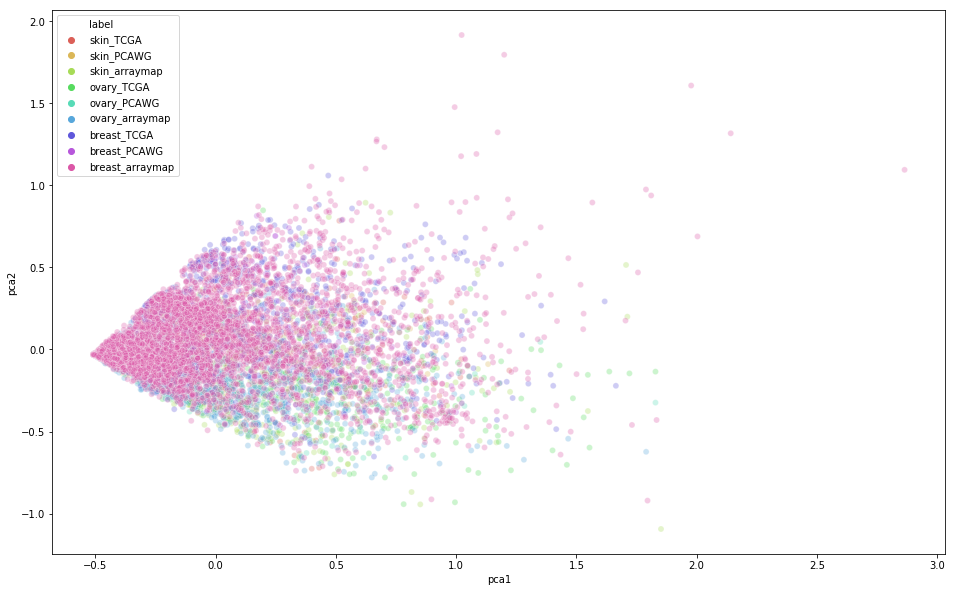

In [18]:
pca_df = pd.DataFrame(pca_result, columns = ['pca1','pca2','pca3','pca4'])
pca_df['label'] = feat_label

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="pca1", y="pca2",
    hue="label",
    palette=sns.color_palette("hls", 9),
    data=pca_df,
    legend="full",
    alpha=0.3
)

TSNE

In [21]:
time_start = time.time()

tsne = TSNE(random_state=RS, perplexity=40).fit_transform(feat_sub)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 96.52448964118958 seconds


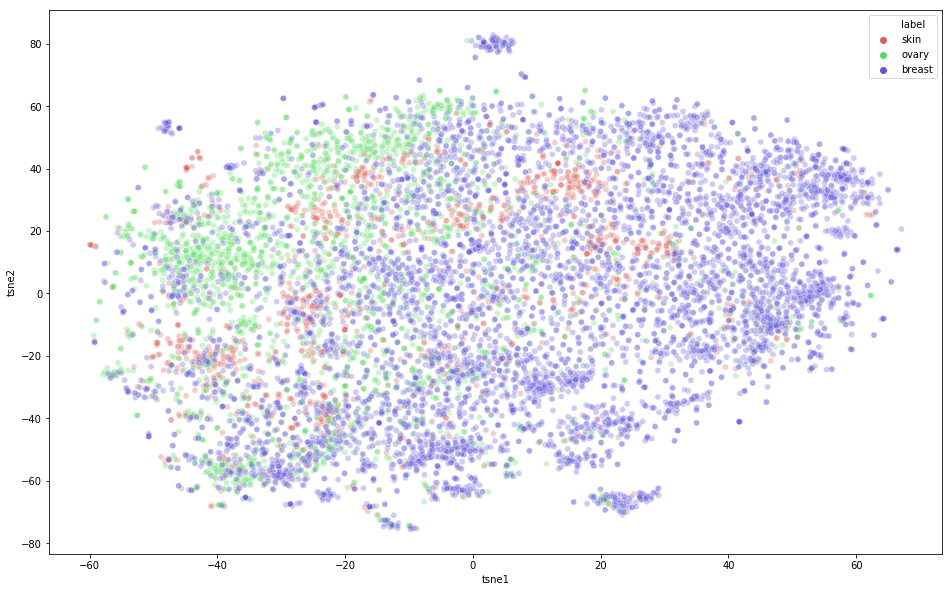

In [28]:
tsne_df = pd.DataFrame(tsne, columns = ['tsne1','tsne2'])
# tsne_df['label'] = feat_label
tsne_df['label'] = feat_label_3

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="label",
#     palette=sns.color_palette("hls", 9),
    palette=sns.color_palette("hls", 3),
    data=tsne_df,
    legend="full",
    alpha=0.3
)

PCA-TSNE

In [33]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(feat_scaled)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.627837507046104


In [37]:
time_start = time.time()
pca_tsne = TSNE(random_state=RS, perplexity=40, learning_rate=800).fit_transform(pca_result_50)
print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 98.55704593658447 seconds


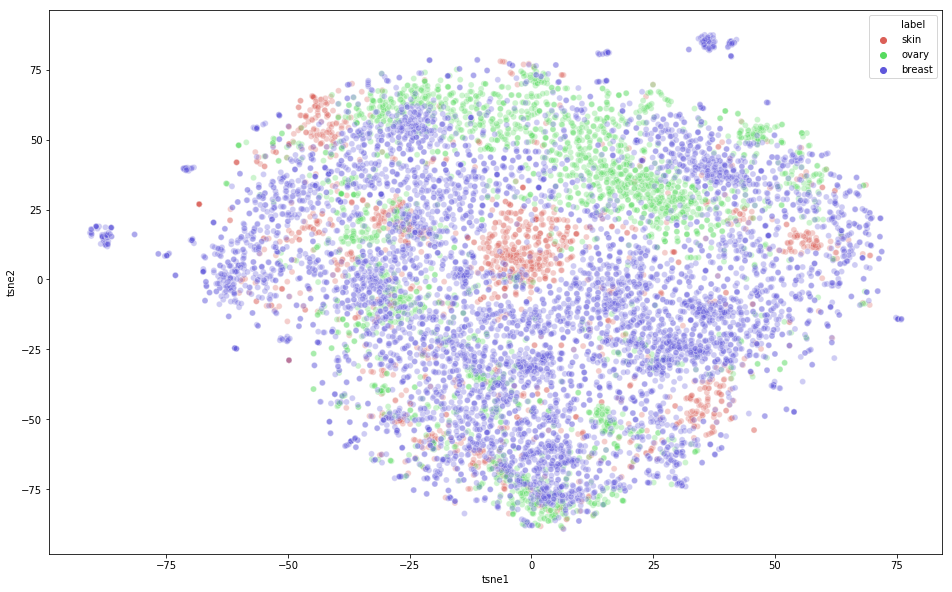

In [39]:
tsne_df = pd.DataFrame(pca_tsne, columns = ['tsne1','tsne2'])
# tsne_df['label'] = feat_label
tsne_df['label'] = feat_label_3

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="label",
#     palette=sns.color_palette("hls", 9),
    palette=sns.color_palette("hls", 3),
    data=tsne_df,
    legend="full",
    alpha=0.3
)

K-means

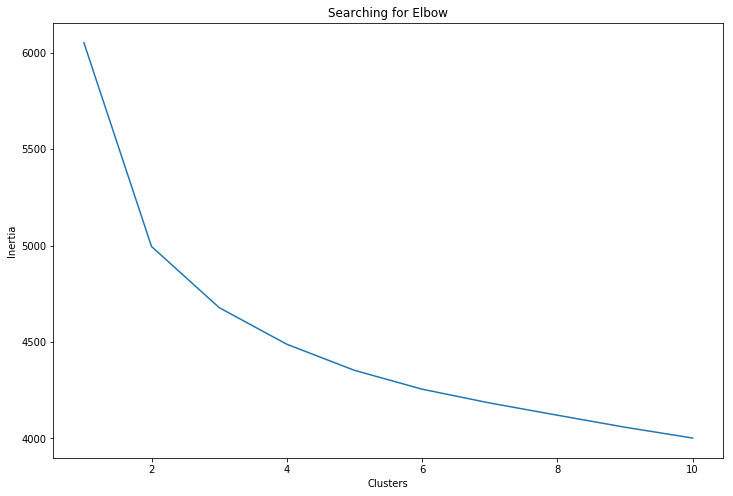

In [29]:
clusters = []

for i in range(1, 11):
    km = KMeans(n_clusters=i).fit(feat_sub)
    clusters.append(km.inertia_)
    
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

plt.show()

In [31]:
km3 = KMeans(n_clusters=3).fit(feat_sub)
km3_df = pd.DataFrame({'km3_label': km3.labels_, 'sample_label':feat_label_3})

<Figure size 1152x720 with 0 Axes>

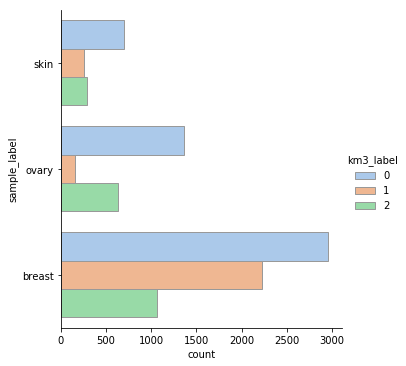

In [32]:
plt.figure(figsize=(16,10))
ax = sns.catplot(y="sample_label", hue="km3_label", kind="count",
            palette="pastel", edgecolor=".6",
            data=km3_df)

Only TCGA data

In [45]:
i = 0
tcga = []
for x in feat_label:
    if 'TCGA' in x:
        tcga.append(i)
    i +=1

In [55]:
feat_tcga = feat_sub.take(tcga, axis=0)

In [52]:
label_tcga = np.array(feat_label_3).take(tcga, axis=0)

PCA

In [59]:
time_start = time.time()

pca = PCA(n_components=2)
pca_result = pca.fit_transform(feat_tcga)

print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))
print ('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

PCA done! Time elapsed: 0.0051059722900390625 seconds
Variance explained per principal component: [0.24113254 0.11401935]


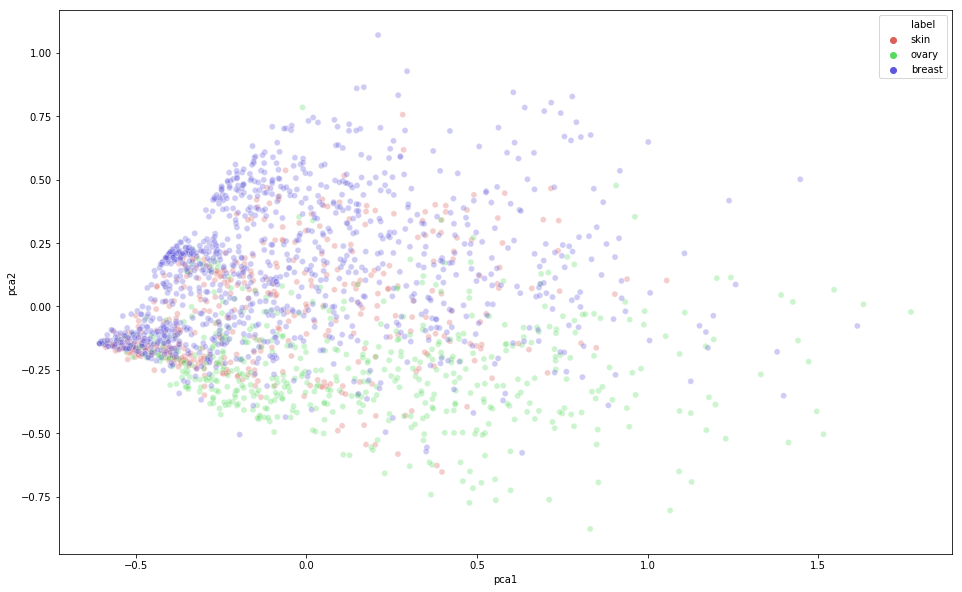

In [61]:
pca_df = pd.DataFrame(pca_result, columns = ['pca1','pca2'])
pca_df['label'] = label_tcga

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="pca1", y="pca2",
    hue="label",
    palette=sns.color_palette("hls", 3),
    data=pca_df,
    legend="full",
    alpha=0.3
)

PCA-TSNE

In [62]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(feat_tcga)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.9532083391452283


In [65]:
time_start = time.time()
pca_tsne = TSNE(random_state=RS).fit_transform(pca_result_50)
print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 13.579034566879272 seconds


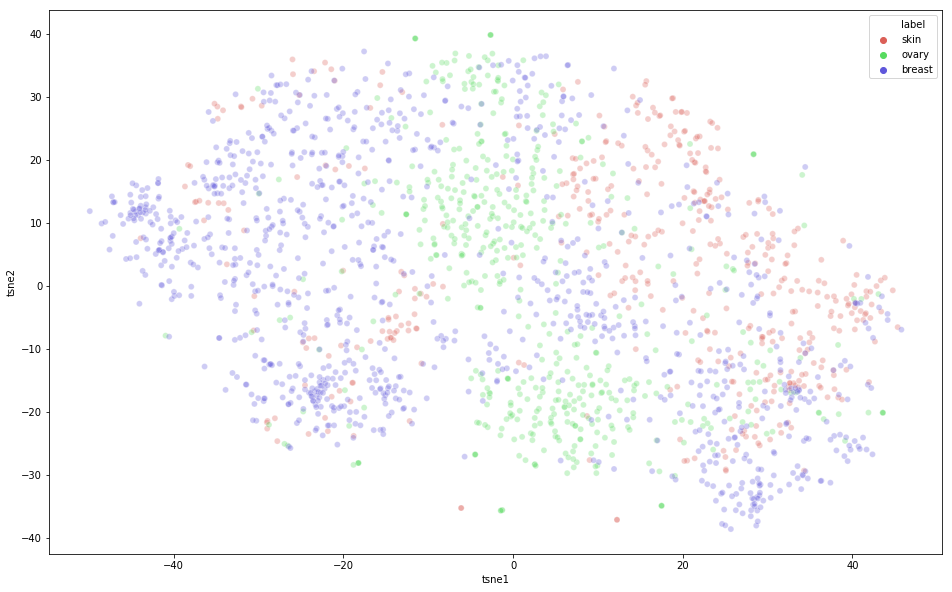

In [66]:
tsne_df = pd.DataFrame(pca_tsne, columns = ['tsne1','tsne2'])
tsne_df['label'] = label_tcga

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="label",
    palette=sns.color_palette("hls", 3),
    data=tsne_df,
    legend="full",
    alpha=0.3
)